In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
from IPython.display import clear_output
import numpy as np
import glob
from pathlib import Path

# General Validation
This chapter has two main ideas:
- Generate a validation/test set
- Validate the already classified data from tina dubach

### Script for manual validation
Assumption: the datapreprocessing into grayscale/rgb and motion/time images is already done (see classifyMotionGray.py)

Enter cameraName for which you want to manually classify the images into five classes: 
- 0: normal image
- 1: small anomaly heron
- 2: big anomaly heron
- 3: small anomaly other
- 4: big anomaly other
- -1: special image

The images you classify are randomly sampled and you'll not classify an image twice

In [9]:
#load classified data from Tina Dubach
try: 
    camName = input("Enter camera name: ")
    dfMotionGray = pd.read_csv(f'/data/tim/heronWorkspace/MotionGrayClassification/classifiedMotionGray{camName}.csv')
except:
    print(f"Error loading file\nEither camera name {camName} is wrong or first classify the files for the camera")
    raise Exception("Error loading file")

try:
    dfValidation = pd.read_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv")
except:
    print("No validation file found, creating new one")
    pd.DataFrame([], columns=["ImagePath", "ValidationValue", "camera"]).to_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv")
    dfValidation = pd.read_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv")

# as motion == True, the training and testing data is distinct
dfMotionGray = dfMotionGray[(dfMotionGray["grayscale"] == False) & (dfMotionGray["badImage"] == False)].sort_values(by=['ImagePath'])
dfMotionGray = dfMotionGray.reset_index(drop=True)

# exclude images that are already classified
dfMotionGray = dfMotionGray[~dfMotionGray["ImagePath"].isin(dfValidation["ImagePath"])]

tinaDubachDf = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
dfMotionGray = pd.merge(tinaDubachDf, dfMotionGray, left_on="fotocode", how="right", right_on="ImagePath")
onlyPositiveTinaDubach = False
# dfValidation = pd.read_csv("/data/tim/heronWorkspace/datasetValidation.csv", on_bad_lines="warn")
print(f'Total len of Dataset: {len(dfMotionGray)}')
    
imgPropsList = []
i = 0
try:
    while True:
        # new sample
        
        #if only want to validation pictures with motion
        if onlyPositiveTinaDubach:
            lenDf = dfMotionGray["species"].notna().sum()
            # print(lenDf)
            sampleIdx = np.random.choice(dfMotionGray[dfMotionGray["species"].notna()].index, np.min([lenDf, 5]), replace=False)
        else:
            lenDf = (dfMotionGray["motion"] == True).sum()
            sampleIdx = np.random.choice(dfMotionGray[dfMotionGray["motion"] == True].index, np.min([lenDf, 5]), replace=False)

        # sampleIdx = np.random.choice(dfMotionGray.index, 5, replace=False)
        print(sampleIdx)
    
        if sampleIdx.size == 0:
            print("No more images to classify")
            break
        
    
        sampleImgs = (dfMotionGray.loc[sampleIdx])["ImagePath"].tolist()
        

        for j, sampleImg in enumerate(sampleImgs):
            print(f"classify image {j+1}")
            if (onlyPositiveTinaDubach):
                print(f'should be species: {(dfMotionGray.loc[sampleIdx[j]])["species"]}')
            img = Image.open(f'/data/shared/herons/TinaDubach_data/{camName}/{sampleImg}.JPG')
            img.draft('RGB',(2448//7, 3264//7)) 
            plt.figure(figsize=(10, 10))
            fig = plt.imshow(img)
            plt.show()

            #enter number (enter non-int to quit)
            
            val = int(input("Enter a number: (0: normal image, 1: small anomaly heron: 2: big anomaly heron, 3: small anomaly other, 4: big anomaly other, -1: special image)"))
            imgPropsList.append([sampleImg, val, camName])
            clear_output(wait=True)
            print(f"last classified image: {sampleImg}")

        dfMotionGray = dfMotionGray.drop(sampleIdx)
        dfMotionGray = dfMotionGray.reset_index(drop=True)
        
        try:
            dfNew = pd.DataFrame(imgPropsList, columns=["ImagePath", "ValidationValue", "camera"])
            dfValidation = pd.concat([dfValidation, dfNew])
            dfValidation.to_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv", index=False)
            imgPropsList = []
            print(f"Saved to file: {sampleImgs}")
        except Exception as e:
            print(e)
            print("Error saving file")
            raise Exception("Error saving file")
            # print(f"Currently at image: {int(i/10) * 10}")

        i += 1


except Exception as e:
    
    clear_output(wait=True)
    print("Quit program")
    print(f"Classified {5 * (i-1)} images")
    
    # analyse current results
    camDataDf = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
    dfValidation = pd.merge(camDataDf, dfValidation, left_on="fotocode", how="right", right_on="ImagePath")
    nrFalsePos = len(dfValidation[(dfValidation["ValidationValue"] > 0) & (dfValidation["species"].isna())])
    nrFalseNeg = len(dfValidation[(dfValidation["ValidationValue"] == 0) & dfValidation["species"].notna()]) # always put conditions in brackets!
    nrTruePos = len(dfValidation[(dfValidation["ValidationValue"] > 0) & dfValidation["species"].notna()])
    nrTrueNeg = len(dfValidation[(dfValidation["ValidationValue"] == 0) & dfValidation["species"].isna()])
    nrNegNew = len( dfValidation[(dfValidation["ValidationValue"]==0)])
    # nrNegOld = len( df[(df["species"].isna()) | (df["fotocode"].isna())])
    nrNegOld = len( dfValidation[(dfValidation["species"].isna())])

    dfMotionGray = pd.read_csv(f'/data/tim/heronWorkspace/MotionGrayClassification/classifiedMotionGray{camName}.csv')
    dfWithMotionFlag = pd.merge(dfValidation, dfMotionGray, on="ImagePath")
    nrPosWithoutMotion = len(dfWithMotionFlag[(dfWithMotionFlag["ValidationValue"] > 0) & (dfWithMotionFlag["motion"] == False)]) 
    # print(dfWithMotionFlag[(dfWithMotionFlag["ValidationValue"] > 0) & (dfWithMotionFlag["motion"] == False)].head(10))

    print('\n\033[1m' + "Evaluation of tina dubachs classification with my classification as true value:")
    print(f"Nr of false positives (positive images now, that aren't in tina dubachs data, FP): {nrFalsePos}")
    print(f"Nr of false negatives (negative images now, that were in tina dubachs data, FN): {nrFalseNeg}")
    print(f"Nr of true positives, TP: {nrTruePos}")
    print(f"Nr of true negatives, TN: {nrTrueNeg}")
    
    print("Evalation of new data:")
    print(f"Nr of images classified as negative now: {nrNegNew}")
    print(f"Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : {nrNegOld}")
    print(f"Nr of images classified positive now, that don't have motion flag: {nrPosWithoutMotion}")

    raise e
    # print(df[df["ValidationValue"] == 0 & df["species"].notna()][["species", "fotocode", "ImagePath", "ValidationValue"]])
    # print(df[["species", "fotocode", "ImagePath", "ValidationValue"]])

last classified image: 2017_PSU1_01180692
Saved to file: ['2017_PSU1_01180692']
[]
No more images to classify


Total len of Dataset: 12251
[5174]


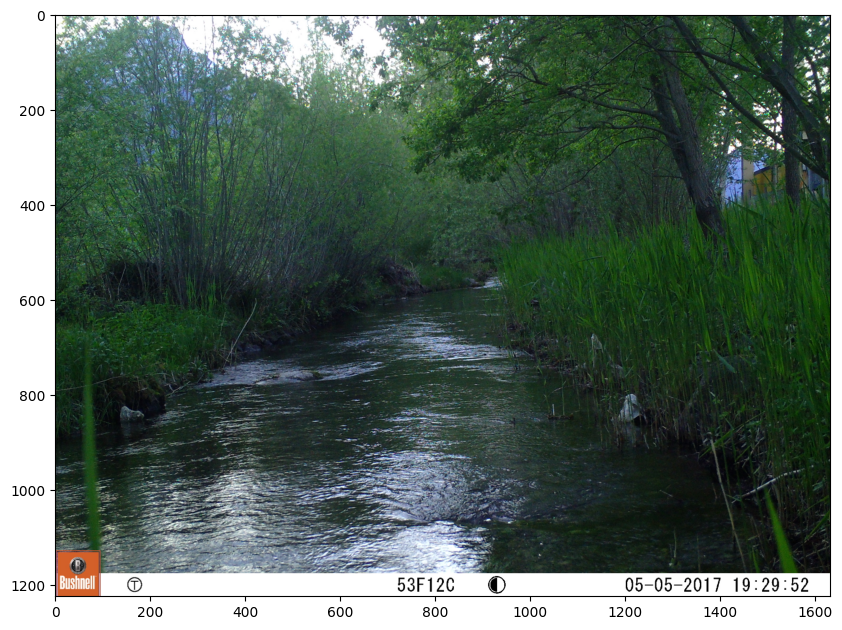

Quit program
Classified 0 images

Evaluation of tina dubachs classification with my classification as true value:
Nr of false positives (positive images now, that aren't in tina dubachs data, FP): 0
Nr of false negatives (negative images now, that were in tina dubachs data, FN): 8
Nr of true positives, TP: 17
Nr of true negatives, TN: 0
Evalation of new data:
Nr of images classified as negative now: 8
Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : 0
Nr of images classified positive now, that don't have motion flag: 10


ValueError: invalid literal for int() with base 10: 'q'

In [5]:
#load classified data from Tina Dubach
try: 
    camName = input("Enter camera name: ")
    dfMotionGray = pd.read_csv(f'/data/tim/heronWorkspace/MotionGrayClassification/classifiedMotionGray{camName}.csv')
except:
    print(f"Error loading file\nEither camera name {camName} is wrong or first classify the files for the camera")
    raise Exception("Error loading file")

try:
    dfValidation = pd.read_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv")
except:
    print("No validation file found, creating new one")
    pd.DataFrame([], columns=["ImagePath", "ValidationValue", "camera"]).to_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv")
    dfValidation = pd.read_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv")

# as motion == True, the training and testing data is distinct
dfMotionGray = dfMotionGray[(dfMotionGray["grayscale"] == False) & (dfMotionGray["badImage"] == False)].sort_values(by=['ImagePath'])
dfMotionGray = dfMotionGray.reset_index(drop=True)

# exclude images that are already classified
dfMotionGray = dfMotionGray[~dfMotionGray["ImagePath"].isin(dfValidation["ImagePath"])]

# dfValidation = pd.read_csv("/data/tim/heronWorkspace/datasetValidation.csv", on_bad_lines="warn")
print(f'Total len of Dataset: {len(dfMotionGray)}')
    
imgPropsList = []
i = 0
try:
    while True:
        # new sample
        
        #if only want to validation pictures with motion
        sampleIdx = np.random.choice(dfMotionGray[dfMotionGray["motion"] == True].index, 1, replace=False)

        # sampleIdx = np.random.choice(dfMotionGray.index, 1, replace=False)
        print(sampleIdx)
    
        if sampleIdx.size == 0:
            print("No more images to classify")
            break
        
        # increase probability to classify three consecutive images
        sampleIdx = sampleIdx[0]
        if sampleIdx == len(dfMotionGray)-1:
            consecutiveSampleIdx = [sampleIdx-1, sampleIdx]
        elif sampleIdx == 0:
            consecutiveSampleIdx = [sampleIdx, sampleIdx+1]
        else:
            consecutiveSampleIdx = [sampleIdx-1, sampleIdx, sampleIdx+1]
    
        sampleImgs = dfMotionGray["ImagePath"].loc[consecutiveSampleIdx].tolist()
        
        dfMotionGray = dfMotionGray.drop(sampleIdx)
        dfMotionGray = dfMotionGray.reset_index(drop=True)

        for sampleImg in sampleImgs:
            img = Image.open(f'/data/shared/herons/TinaDubach_data/{camName}/{sampleImg}.JPG')
            img.draft('RGB',(2448//5, 3264//5)) 
            plt.figure(figsize=(10, 10))
            fig = plt.imshow(img)
            plt.show()

            #enter number (enter non-int to quit)
            
            val = int(input("Enter a number: (0: normal image, 1: small anomaly heron: 2: big anomaly heron, 3: small anomaly other, 4: big anomaly other, -1: special image)"))
            imgPropsList.append([sampleImg, val, camName])
            clear_output(wait=True)


        
        try:
            dfNew = pd.DataFrame(imgPropsList, columns=["ImagePath", "ValidationValue", "camera"])
            dfValidation = pd.concat([dfValidation, dfNew])
            dfValidation.to_csv(f"/data/tim/heronWorkspace/manuallyClassified/manuallyClassified{camName}.csv", index=False)
            imgPropsList = []
            print(f"Saved to file: {sampleImgs}")
        except Exception as e:
            print(e)
            print("Error saving file")
            raise Exception("Error saving file")
            # print(f"Currently at image: {int(i/10) * 10}")

        i += 1


except Exception as e:
    
    clear_output(wait=True)
    print("Quit program")
    print(f"Classified {int(i/10) * 10} images")
    
    # analyse current results
    camDataDf = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
    dfValidation = pd.merge(camDataDf, dfValidation, left_on="fotocode", how="right", right_on="ImagePath")
    nrFalsePos = len(dfValidation[(dfValidation["ValidationValue"] > 0) & (dfValidation["species"].isna())])
    nrFalseNeg = len(dfValidation[(dfValidation["ValidationValue"] == 0) & dfValidation["species"].notna()]) # always put conditions in brackets!
    nrTruePos = len(dfValidation[(dfValidation["ValidationValue"] > 0) & dfValidation["species"].notna()])
    nrTrueNeg = len(dfValidation[(dfValidation["ValidationValue"] == 0) & dfValidation["species"].isna()])
    nrNegNew = len( dfValidation[(dfValidation["ValidationValue"]==0)])
    # nrNegOld = len( df[(df["species"].isna()) | (df["fotocode"].isna())])
    nrNegOld = len( dfValidation[(dfValidation["species"].isna())])

    dfMotionGray = pd.read_csv(f'/data/tim/heronWorkspace/MotionGrayClassification/classifiedMotionGray{camName}.csv')
    dfWithMotionFlag = pd.merge(dfValidation, dfMotionGray, on="ImagePath")
    nrPosWithoutMotion = len(dfWithMotionFlag[(dfWithMotionFlag["ValidationValue"] > 0) & (dfWithMotionFlag["motion"] == False)]) 
    # print(dfWithMotionFlag[(dfWithMotionFlag["ValidationValue"] > 0) & (dfWithMotionFlag["motion"] == False)].head(10))

    print('\n\033[1m' + "Evaluation of tina dubachs classification with my classification as true value:")
    print(f"Nr of false positives (positive images now, that aren't in tina dubachs data, FP): {nrFalsePos}")
    print(f"Nr of false negatives (negative images now, that were in tina dubachs data, FN): {nrFalseNeg}")
    print(f"Nr of true positives, TP: {nrTruePos}")
    print(f"Nr of true negatives, TN: {nrTrueNeg}")
    
    print("Evalation of new data:")
    print(f"Nr of images classified as negative now: {nrNegNew}")
    print(f"Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : {nrNegOld}")
    print(f"Nr of images classified positive now, that don't have motion flag: {nrPosWithoutMotion}")

    raise e
    # print(df[df["ValidationValue"] == 0 & df["species"].notna()][["species", "fotocode", "ImagePath", "ValidationValue"]])
    # print(df[["species", "fotocode", "ImagePath", "ValidationValue"]])

## Stats about manually classified data

In [6]:
def printStatsTinaDubach(dfManuallyValidated:pd.DataFrame):
    camDataDf = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
    dfManuallyValidated = pd.merge(camDataDf, dfManuallyValidated, left_on="fotocode", how="right", right_on="ImagePath")
    nrFalsePos = len(dfManuallyValidated[(dfManuallyValidated["ValidationValue"] > 0) & (dfManuallyValidated["species"].isna())])
    nrFalseNeg = len(dfManuallyValidated[(dfManuallyValidated["ValidationValue"] == 0) & dfManuallyValidated["species"].notna()]) # always put conditions in brackets!
    nrTruePos = len(dfManuallyValidated[(dfManuallyValidated["ValidationValue"] > 0) & dfManuallyValidated["species"].notna()])
    nrTrueNeg = len(dfManuallyValidated[(dfManuallyValidated["ValidationValue"] == 0) & dfManuallyValidated["species"].isna()])
    nrNegNew = len( dfManuallyValidated[(dfManuallyValidated["ValidationValue"]==0)])
    nrPosNew = len( dfManuallyValidated[(dfManuallyValidated["ValidationValue"]>0)])
    nrCurruptNew = len( dfManuallyValidated[(dfManuallyValidated["ValidationValue"]==-1)])
    # nrNegOld = len( df[(df["species"].isna()) | (df["fotocode"].isna())])
    nrNegOld = len( dfManuallyValidated[(dfManuallyValidated["species"].isna())])


    print("Totoal number of images in validation data: ", len(dfManuallyValidated))

    print("Evaluation of tina dubachs classification with my classification as true value:")
    print(f"Nr of false positives (positive images now, that aren't in tina dubachs data, FP): {nrFalsePos}")
    print(f"Nr of false negatives (negative images now, that were in tina dubachs data, FN): {nrFalseNeg}")
    print(f"Nr of true positives, TP: {nrTruePos}")
    print(f"Nr of true negatives, TN: {nrTrueNeg}")
    
    print("Evalation of new data:")
    print(f"Nr of images classified as negative now: {nrNegNew}")
    print(f"Nr of images classified as positive now: {nrPosNew}")
    print(f"Nr of images classified as currupt now: {nrCurruptNew}")
    print(f"Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : {nrNegOld}")

In [7]:
path = '/data/tim/heronWorkspace/manuallyClassified/' # use your path
all_files = glob.glob(os.path.join(path , "/*.csv"))
all_files = Path(path).glob('*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    # unwanted = df.columns[df.columns.str.startswith('Unnamed')]
    # df.drop(unwanted, axis=1, inplace=True)
    # df["camera"] = [filename.name[-8:-4] for i in range(len(df))]
    # df.to_csv(filename, index=False)
    li.append(df)


df = pd.concat(li, ignore_index=True)
printStatsTinaDubach(df)
df = df.groupby("camera")["ValidationValue"].agg([('anomaly', lambda x: (x > 0).sum()), ('normal', lambda x: (x == 0).sum()), ('total', 'count')])
df

Totoal number of images in validation data:  2742
Evaluation of tina dubachs classification with my classification as true value:
Nr of false positives (positive images now, that aren't in tina dubachs data, FP): 398
Nr of false negatives (negative images now, that were in tina dubachs data, FN): 13
Nr of true positives, TP: 224
Nr of true negatives, TN: 2088
Evalation of new data:
Nr of images classified as negative now: 2101
Nr of images classified as positive now: 622
Nr of images classified as currupt now: 19
Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : 2504


,anomaly,normal,total
camera,,,
NEN1,190,442,637
NEN3,3,17,20
SBU3,46,424,484
SBU4,382,1218,1600


In [11]:
dfValidation = pd.read_csv("/data/tim/heronWorkspace/ImageData/imagePropsSBU4.csv", on_bad_lines="warn")
dfValidation = dfValidation[dfValidation["grayscale"] == "False"].sort_values(by=['ImagePath'])
dfValidation.head(10)

,Unnamed: 0,cam,ImagePath,badImage,motion,grayscale
5223,5223,15.0,2017_SBU4_01270001,False,False,False
15224,15224,15.0,2017_SBU4_01270002,False,True,False
18724,18724,15.0,2017_SBU4_01270003,False,False,False
5150,5150,15.0,2017_SBU4_01270004,False,False,False
8334,8334,15.0,2017_SBU4_01270005,False,False,False
1043,1043,15.0,2017_SBU4_01270006,False,False,False
7698,7698,15.0,2017_SBU4_01270007,False,False,False
15114,15114,15.0,2017_SBU4_01280069,False,False,False
18917,18917,15.0,2017_SBU4_01280070,False,False,False
9496,9496,15.0,2017_SBU4_01280071,False,False,False


# specific validation for SBU4

In [11]:
#load classified data from Tania
dfSBU4 = pd.read_csv("/data/tim/heronWorkspace/ImageData/imagePropsSBU4.csv", on_bad_lines="warn")
dfSBU4 = dfSBU4[(dfSBU4["grayscale"] == "False") & (dfSBU4["badImage"] == "False")].sort_values(by=['ImagePath'])
dfValidation = pd.read_csv("/data/tim/heronWorkspace/datasetValidation.csv", on_bad_lines="warn")
print(f'Total len of SBU4: {len(dfSBU4)}')

try:
    currIndex = int(input("Enter index from last time: "))
except ValueError:
    print("not a number")
    
imgPropsList = []
for i, imgName in list(enumerate(dfSBU4["ImagePath"]))[currIndex:]:
    img = Image.open(f'/data/shared/herons/TinaDubach_data/SBU4/{imgName}.JPG')
    plt.figure(figsize=(10, 10))
    fig = plt.imshow(img)
    plt.show()

    #enter number
    try:
        val = int(input("Enter a number: (0: normal image, 1: small anomaly heron: 2: big anomaly heron, 3: small anomaly other, 4: big anomaly other, -1: special image)"))
        imgPropsList.append([imgName, val])
    except ValueError:
        clear_output(wait=True)
        print("Quit program")
        print(f"Currently at image: {int(i/10) * 10}")
        
        # analyse current results
        camDataDf = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
        dfValidation = pd.merge(camDataDf, dfValidation, left_on="fotocode", how="right", right_on="ImagePath")
        nrFalsePos = len(dfValidation[(dfValidation["ValidationValue"] > 0) & (dfValidation["species"].isna())])
        nrFalseNeg = len(dfValidation[(dfValidation["ValidationValue"] == 0) & dfValidation["species"].notna()]) # always put conditions in brackets!
        nrTruePos = len(dfValidation[(dfValidation["ValidationValue"] > 0) & dfValidation["species"].notna()])
        nrTrueNeg = len(dfValidation[(dfValidation["ValidationValue"] == 0) & dfValidation["species"].isna()])
        nrNegNew = len( dfValidation[(dfValidation["ValidationValue"]==0)])
        # nrNegOld = len( df[(df["species"].isna()) | (df["fotocode"].isna())])
        nrNegOld = len( dfValidation[(dfValidation["species"].isna())])

        dfWithMotionFlag = pd.merge(dfValidation, dfSBU4, on="ImagePath")
        # print(dfWithMotionFlag.head(10))
        nrPosWithoutMotion = len(dfWithMotionFlag[(dfWithMotionFlag["ValidationValue"] > 0) & (dfWithMotionFlag["motion"] == "False")]) 

        print("Evaluation of tina dubachs classification with my classification as true value:")
        print(f"Nr of false positives (positive images now, that aren't in tina dubachs data, FP): {nrFalsePos}")
        print(f"Nr of false negatives (negative images now, that were in tina dubachs data, FN): {nrFalseNeg}")
        print(f"Nr of true positives, TP: {nrTruePos}")
        print(f"Nr of true negatives, TN: {nrTrueNeg}")
        
        print("Evalation of new data:")
        print(f"Nr of images classified as negative now: {nrNegNew}")
        print(f"Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : {nrNegOld}")
        print(f"Nr of images classified positive now, that don't have motion flag: {nrPosWithoutMotion}")

        # print(df[df["ValidationValue"] == 0 & df["species"].notna()][["species", "fotocode", "ImagePath", "ValidationValue"]])
        # print(df[["species", "fotocode", "ImagePath", "ValidationValue"]])
        break

    if i % 10 == 9:
        try:
            dfNew = pd.DataFrame(imgPropsList, columns=["ImagePath", "ValidationValue"])
            dfValidation = pd.concat([dfValidation, dfNew])
            dfValidation.to_csv("/data/tim/heronWorkspace/datasetValidation.csv")
            imgPropsList = []
            print(f"Saved file up to index:{i}")
        except Exception as e:
            print(e)
            print("Error saving file")
            print(f"Currently at image: {int(i/10) * 10}")
            break

    clear_output(wait=True)

Quit program
Currently at image: 10250
Evaluation of tina dubachs classification with my classification as true value:
Nr of false positives (positive images now, that aren't in tina dubachs data, FP): 196
Nr of false negatives (negative images now, that were in tina dubachs data, FN): 9
Nr of true positives, TP: 186
Nr of true negatives, TN: 1209
Evalation of new data:
Nr of images classified as negative now: 1218
Total Nr of images that aren't in tina dubachs positive data (were classified as negative before) : 1405
Nr of images classified positive now, that don't have motion flag: 247


In [19]:
# df = df[df["species"].notna() & (df["ValidationValue"] == 0)]
# df = df[df["species"].notna()]
dfValidation[["species", "fotocode", "ImagePath", "ValidationValue"]]

,species,fotocode,ImagePath,ValidationValue
0,NaN,NaN,2017_SBU4_01270001,0
1,NaN,NaN,2017_SBU4_01270002,0
2,NaN,NaN,2017_SBU4_01270003,0
3,NaN,NaN,2017_SBU4_01270004,0
4,NaN,NaN,2017_SBU4_01270005,0
5,NaN,NaN,2017_SBU4_01270006,0
6,NaN,NaN,2017_SBU4_01270007,0
7,NaN,NaN,2017_SBU4_01280069,0
8,NaN,NaN,2017_SBU4_01280070,4
9,NaN,NaN,2017_SBU4_01280071,0
